# Finding Donors: Income Prediction Case Study

## Problem Framing

In this case of study, we employ several supervised algorithms to accurately model individuals' income using data collected from the 1994 U.S. Census. We then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. The goal of this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features.

## Data Overview

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `fnlwgt` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
The code cell below loads necessary Python libraries and the census data. Note that the last column from this dataset, `income`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [2]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames
import sys
from pathlib import Path

# Add the repository root to Python path so "src" can be imported
repo_root = Path().resolve().parent if Path().resolve().name == "notebooks" else Path().resolve()
sys.path.insert(0, str(repo_root))

# Import supplementary visualization code visuals.py
from src import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv(repo_root / "data/census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Data overview (quick EDA)
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, we compute the following:
- The total number of records, `n_records`
- The number of individuals making more than \$50,000 annually, `n_greater_50k`.
- The number of individuals making at most \$50,000 annually, `n_at_most_50k`.
- The percentage of individuals making more than \$50,000 annually, `greater_percent`.

In [3]:
# Total number of records
n_records = data.shape[0]

# Number of records where individual's income is more than $50,000
n_greater_50k = data["income"].value_counts()[">50K"]

# Number of records where individual's income is at most $50,000
n_at_most_50k = data["income"].value_counts()["<=50K"]

# Percentage of individuals whose income is more than $50,000
greater_percent = (n_greater_50k / n_records) * 100

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78439697492371%


**Featureset Exploration**

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Preparing the Data
Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: `capital-gain` and `capital-loss`. 

The code cell below plots a histogram of these two features. Note the range of the values present and how they are distributed.

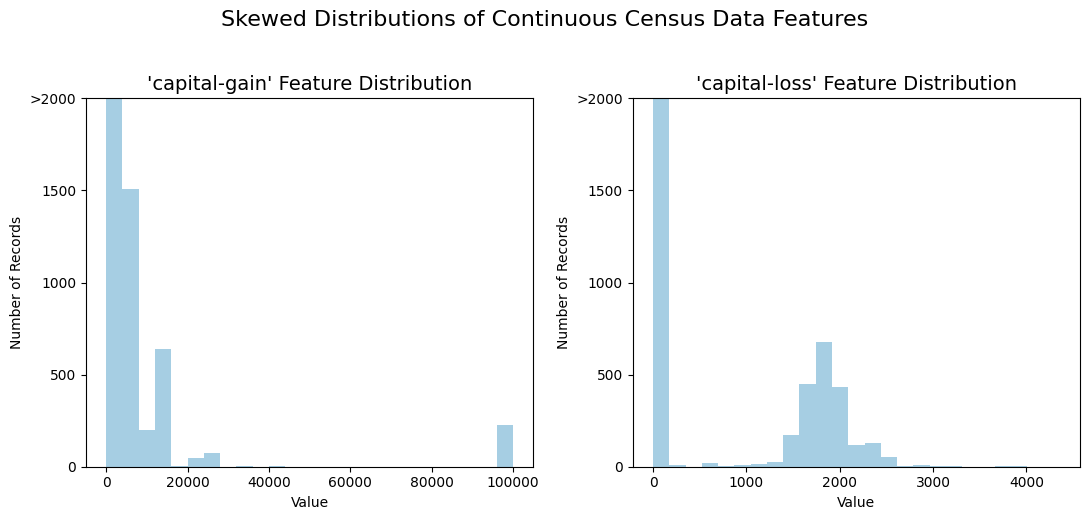

In [4]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `capital-gain` and `capital-loss`, it is common practice to apply a [logarithmic transformation](https://en.wikipedia.org/wiki/Data_transformation_(statistics)) on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of 0 is undefined, so we must translate the values by a small amount above 0 to apply the the logarithm successfully.

The code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

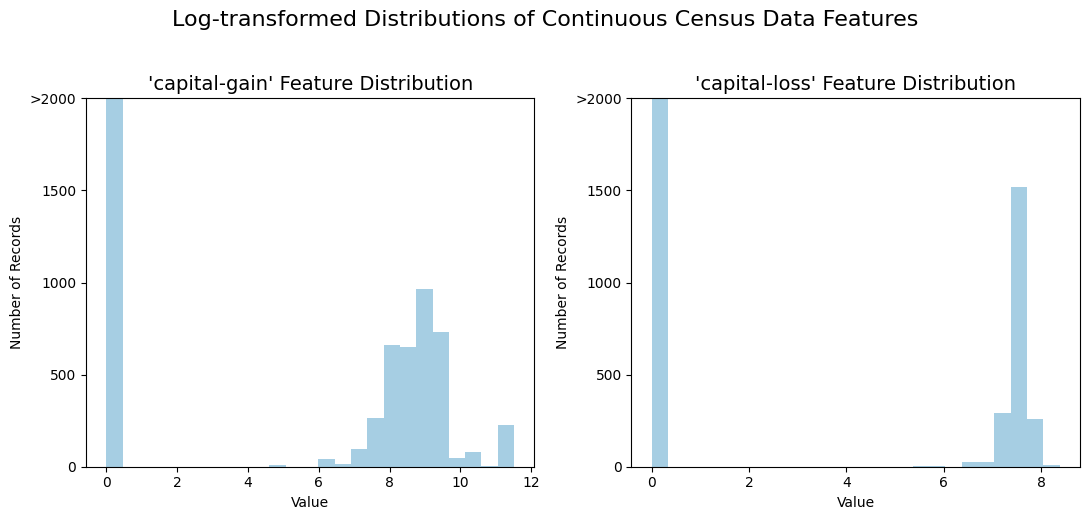

In [5]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `capital-gain` or `capital-loss` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

The code cell below normalizes each numerical feature. We use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [6]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Preprocessing pipeline

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. We use One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. 

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `income` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as 0 and 1, respectively. In code cell below, we implement the following: 
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `features_log_minmax_transform` data.
 - Convert the target label `income_raw` to numerical entries.
 - Set records with "<=50K" to 0 and records with ">50K" to 1.

In [7]:
# One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()

# A list of the categorical column names
cat_features = features_log_minmax_transform.select_dtypes(include=["object"])
cat_cols = cat_features.columns

# Drop original categorical features and create dummies for them
features_final = pd.concat(
    [
        features_log_minmax_transform.drop(cat_cols, axis=1),  # Drop all categorical columns
        pd.get_dummies(features_log_minmax_transform[cat_cols], prefix=cat_cols, prefix_sep='_', drop_first=True)  # Create dummies for all categorical columns
    ],
    axis=1
)

# Encode the 'income_raw' data to numerical values
income = income_raw.copy()
income = income_raw.map({">50K": 1, "<=50K": 0}).astype(int)

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

# Uncomment the following line to see the encoded feature names
#print(encoded)
#print(income.head())
#print(features_final.head())

95 total features after one-hot encoding.


### Train/test split
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.
The code cell below to perform this split.

In [8]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners, and the fourth algorithm is a *naive predictor*.

### Baseline + metrics
For this case of study we make the assumption that individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, we are particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, and for this study case, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental, since we are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most `$50,000`, and those who make more), it's clear most individuals do not make more than `$50,000`. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than `$50,000`"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than `$50,000`, we would identify no one as donors.

### Naive Predictor Performace
We generating a naive predictor to show what a base model without any intelligence would look like. Ideally the base model would be either the results of a previous model or could be based on a research paper upon which you are looking to improve. 


In [9]:
TP = np.sum(income) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data encoded to numerical values done in the data preprocessing step.
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case

# Calculate accuracy, precision and recall
accuracy = (TP + TN)/(TP + TN + FP + FN)
recall = TP / (TP + FN)
precision = TP / (TP + FP)

# Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
fscore = ((1 + 0.5**2) * precision * recall)/((0.5**2 * precision) + recall)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))      

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Models Compared


Next, we list three supervised learning models that are appropriate for this problem to test on the census data. 

Considering possible computational restrictions, performance and fast convergence, I decided to select the best three models considering the following: A robust model with some computational needs but with a possible great performance; a good baseline model which mean, fast and reliable; and one that shares the characteristics of these both worlds, always of course trying to get the best metrics.

Having this in mind I select:
##### AdaBoost (Ensemble method) (Top performer candidate)
- What are the strengths of the model; when does it perform well?	
	- Focuses on difficult examples: Since in each round AdaBoost increases the weight of misclassified samples, the next weak learner will concentrate more on this misclassified points. This mean it can perform well when there's low label noise and there are "genuine" misclassified points.
	- Improve weak learners significantly: Since each learner adds a small, targeted correction to the ensemble, stacking these corrections translates into a very defined nonlinear decision function. It can have good performance just by having a base learner performing better than chance.
	- Reduces bias while keeping variance moderate: The idea of boosting is to attack underfitting. The model would add complexity only where needed.
	- Implicit feature selection: Since in each round the idea is to choose the most discriminative split, informative features tend to be reused while weak ones might not appear. This create the idea of selecting influential features while training. It could be helpful if we expect our dataset to have only a subset of futures that are truly influential.

- What are the weaknesses of the model; when does it perform poorly?
	- Sensitive to noise and outliers: AdaBoost add weight to every misclassified sample. Mislabeled points or extreme outliers can bende the boundaries toward noise. If there are too many non-trivial label errors or many outliers it can perform poorly.
	- Requires careful tuning: Overly expressive weak learners can overfit, tiny steps with too few rounds can underfit. Balancing important hyperparameters like learning rate or number of estimators can be crucial.

- What makes this model a good candidate for the problem, given what you know about the data?
	With AdaBoost and shallow trees for example, we can reduce bias with the targeted correction approach. Focuses on hard cases and by adjusting class/instance weighting we can emphasize the class imbalance. It is a medium to high size dataset wit 45222 samples and 95 features after one-hot encoding so we need to be aware of the trade off by using conservative settings when tuning. It can be a robust choice for Finding Donors classification.


##### Logistic Regression (Fast, dependable baseline)
- What are the strengths of the model; when does it perform well?
	- Interpretable: With logistic regression the model learns one weight per feature plus an intercept with each weight telling how changing that feature shifts the log-odds (and their probability) for the positive class. This allow us to explain the direction and magnitud in which a feature can affect our target/positive value.
	- Usable probabilities (Decision threshold): The model outputs a probability between 0 and 1. From there, we can set a decision threshold to match our goal. For example, to catch more positive values we can lower that threshold, to avoid false alarms we can higher it.
	- Efficient training with optimum solution: When fitting a logistic regression model the model doesn't get stuck in some local minima. Training is fast and memory efficient even with many samples or sparse features. It could be beneficial with a medium to large dataset with features mostly numeric or one-hot encoded without the need of heavy compute.
	 
- What are the weaknesses of the model; when does it perform poorly?
	- Underfitting on nonlinear problems: We logistic regression we assume the log-odds of the outcome is a linear combination of the features. If the relationship is actually expressed with non-linear/complex interactions between features the model can underfit.
	- Multicollinearity: When the features are strongly correlated (for example overlapping one hot dummies), coefficients become unstable which hurts interpretability and generalization. It would be important to be aware of the correlated features (drop/merge them), do dimensionality reduction or use regularization.
	- Sensitive to outliers: Extreme values can pull the boundary. With only a few positive, estimates can get noisy and uncertain.
	
- What makes this model a good candidate for the problem, given what you know about the data?
	It could work as a strong, practical baseline before using other heavier nonlinear models/ensembles. The medium-sized, tabular classification task of 45.222 samples with many sparse one hot features and already scaled numerical data is ideal for a regularized logistic model. Coefficients are interpretable which allows to to check on feature importance and selections for our target (in their magnitude and direction). With class_weight="balance" we could address the 24.78% positive case of class imbalance.

##### Random Forest (Ensemble method) (balanced)
- What are the strengths of the model; when does it perform well?	
	- Works well on clean data: When working with data where labels are mostly correct and features carry real signal, it means low label noise, the different trees would majorly agree on the same patterns meaning a strong generalization too.
	- Less sensitive to noise: When dealing with outliers or moderate noisy features their effect can be diluted by the averaging. The feature sampling part also prevents any single noisy feature from dominating each split.
	- Reduces variance through averaging: unless single decision trees, random forest decorrelate the features by training many decision trees on bootstrap samples and in a random subset of features on each split. It reduces variance and overfitting.
	- Feature importance can be obtained: We can obtain variability importance from the algorithm which can be very helpful when identifying which inputs drive predictions.

- What are the weaknesses of the model; when does it perform poorly?
	- Computationally heavy: Random Forest algorithm trains and store many trees, depending on the number of samples, features and tres, memory can be an important aspect..
	- Less interpretable: in comparison to other models, like decision trees rules, Random forest losses that interpretability advantage. However it is still possible to get some feature importance through additional methods.
	- Imbalanced classes could be a problem: Majority vote can favor the prevalent class unless we adjust class weights or sampling.
	
- What makes this model a good candidate for the problem, given what you know about the data?
	Given the characteristics of the dataset (45222 records and 95 features after one-hot encoding) single decision trees could overfit and not generalize well. With Random Forest we can reduce variance and obtain a stable generalization while still capturing nonlinearities. It is a robust option to irrelevant noise and we can get, after some extra steps, the feature importance to understand the inputs that could drive predictions. To get better result we have the option to adjust class weight to handle the class imbalance in our dataset.

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model, it's important to create a training and predicting pipeline that allows us to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. 

In [10]:
# Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import accuracy_score, fbeta_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}

    X_train_sample = X_train[:sample_size]
    y_train_sample = y_train[:sample_size]   
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train_sample, y_train_sample)
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start  
        
    # Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train_sample[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train_sample[:300], predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test, )
    
    # Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train_sample[:300], predictions_train, beta=0.5)
        
    # Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, the following is implemented:
- Import the three supervised learning models discussed in the previous section.
- Initialize the three models and store them in `clf_A`, `clf_B`, and `clf_C`.
  - Use a `random_state` for each model.
  - **Note:** I used the default settings for each model — we will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `samples_1`, `samples_10`, and `samples_100` respectively.

LogisticRegression trained on 361 samples.
LogisticRegression trained on 3617 samples.
LogisticRegression trained on 36177 samples.
RandomForestClassifier trained on 361 samples.
RandomForestClassifier trained on 3617 samples.
RandomForestClassifier trained on 36177 samples.
AdaBoostClassifier trained on 361 samples.
AdaBoostClassifier trained on 3617 samples.
AdaBoostClassifier trained on 36177 samples.


C:\Users\amir_\OneDrive\Documentos\Etudes\machine-learning\introduction-to-machine-learning-with-pytorch\project\finding-donors-ml\src\visuals.py:125: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  pl.tight_layout()


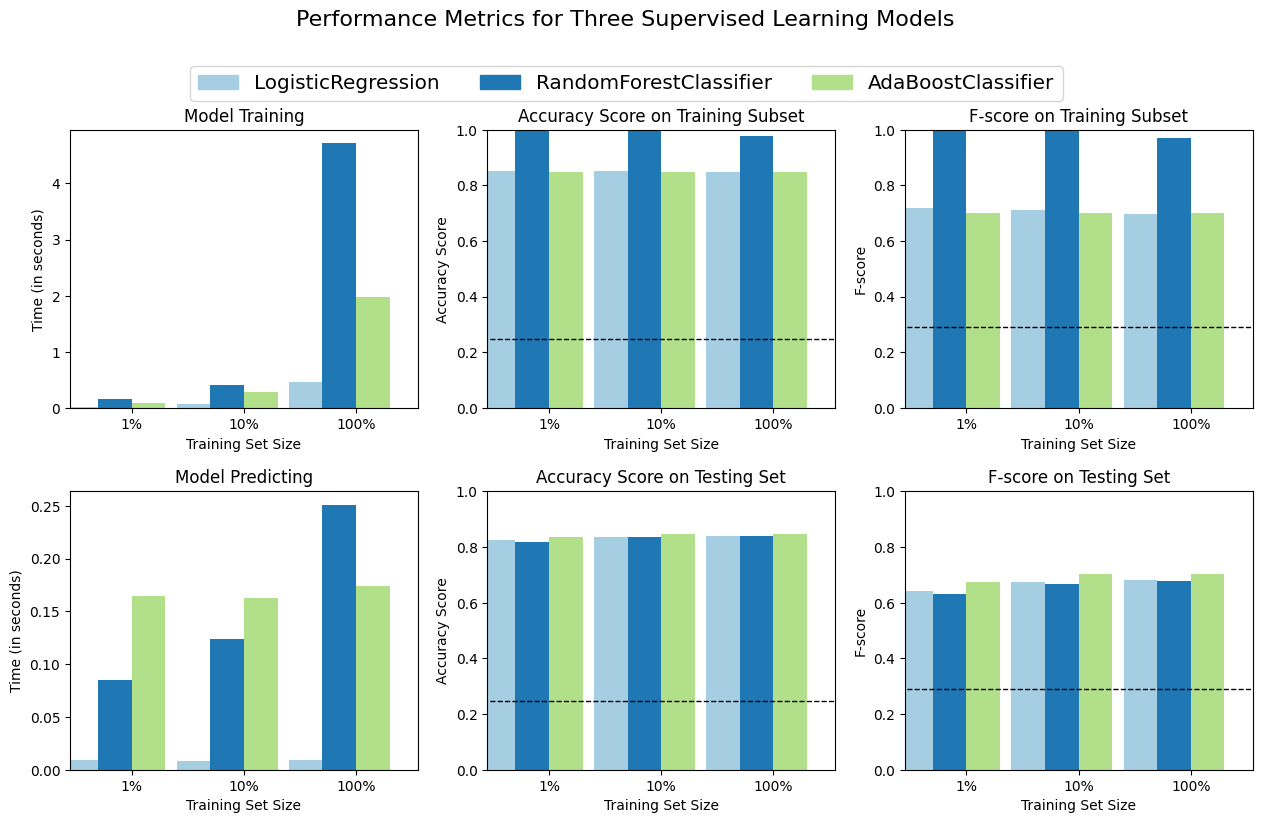

In [11]:
# Import the three supervised learning models from sklearn
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Initialize the three models
clf_A = LogisticRegression(random_state=0)
clf_B = RandomForestClassifier(random_state=0)
clf_C = AdaBoostClassifier(random_state=0)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_100 = len(y_train)
samples_10 = int(0.1 * len(y_train))
samples_1 = int(0.01 * len(y_train))    

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

In [12]:
print(f"Logistic Regression F0.5 on testing for 100% training data:  {results['LogisticRegression'][2]['f_test']:.3f}")
print(f"Random Forest F0.5 on testing for 100% training data:  {results['RandomForestClassifier'][2]['f_test']:.3f}")
print(f"AdaBoost F0.5 on testing for 100% training data:  {results['AdaBoostClassifier'][2]['f_test']:.3f}")
print()
print(f"Logistic Regression Training Time for 100% training data:  {results['LogisticRegression'][2]['train_time']:.3f}")
print(f"Random Forest Training Time for 100% training data:  {results['RandomForestClassifier'][2]['train_time']:.3f}")
print(f"AdaBoost Training Time for 100% training data:  {results['AdaBoostClassifier'][2]['train_time']:.3f}")
print()
print(f"Logistic Regression Prediction Time for 100% training data:  {results['LogisticRegression'][2]['pred_time']:.3f}")
print(f"Random Forest Prediction Time for 100% training data:  {results['RandomForestClassifier'][2]['pred_time']:.3f}")
print(f"AdaBoost Prediction Time for 100% training data:  {results['AdaBoostClassifier'][2]['pred_time']:.3f}")



Logistic Regression F0.5 on testing for 100% training data:  0.683
Random Forest F0.5 on testing for 100% training data:  0.680
AdaBoost F0.5 on testing for 100% training data:  0.703

Logistic Regression Training Time for 100% training data:  0.457
Random Forest Training Time for 100% training data:  4.722
AdaBoost Training Time for 100% training data:  1.980

Logistic Regression Prediction Time for 100% training data:  0.009
Random Forest Prediction Time for 100% training data:  0.251
AdaBoost Prediction Time for 100% training data:  0.174


#### Result Table



| Model (100% train) | F0.5 Test  | Training Time (s) | Prediction Time (s) |
|---|---:|---:|---:|
| Logistic Regression | 0.683 | 0.539 | 0.009 |
| Random Forest | 0.680 | 4.626 | 0.245 |
| AdaBoost | 0.703 | 1.966 | 0.162 |


----
## Best Model + tuning + explanation
In this final section, we choose from the three supervised learning models the *best* model to use on the student data. We will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Model Selection

From the evaluation metrics for the three supervised learning models, the model will be selected by weighing: Metric (F-score (β=0.5)) on the test set when 100% of the training data is used, training/prediction time, and suitability our data.

**Metrics:** F0.5 is used to emphasize precision, which aligns with CharityML’s goal of accurately identifying people earning >$50K. At 100% training, AdaBoost achieves the highest test F0.5 = 0.703, ahead of Logistic Regression (0.683) and Random Forest (0.680). So based on only on this, AdaBoost would be a top choice.

**Prediction/training time:** Logistic Regression is fastest (train 0.423 s; predict 0.012 s), but it stays slightly behind on F0.5. Random Forest is slowest (train 5.318 s; predict 0.259 s) and still underperforms. AdaBoost, as expected, is a balanced approach (train 2.255 s; predict 0.162 s) while delivering the best F0.5.

**Suitability for the data:** The medium-sized, one-hot-encoded tabular data might include non-linear relationships. Logistic Regression can underfit these patterns and Random Forest is heavier without a gain in F0.5. AdaBoost, using boosted shallow trees, captures key interactions efficiently and aligns with our precision objective.

**Conclusion:** Based on metrics, efficiency, and fit, **AdaBoost** is the selected model. It can likely improve by tuning n_estimators and learning_rate, and by calibrating the decision threshold (or using class weights).

### Describing the Model in Layman's Terms

In order to identify potential donors , we trained a model called AdaBoost using many examples where income is known (above or below `$50K`). With AdaBoost, picture an assembly line with several simple inspectors. Each inspector checks one small thing. After a practice run, they review what they missed and pay extra attention to those tricky items next time. Over time, inspectors who prove more reliable earn a stronger voice in the final decision.

When we see a new person’s information (age, education, hours worked, etc.), every inspector gives a quick yes/no vote (above or below `$50K`) on whether they look like a strong outreach candidate. The reliable inspectors’ voices count more, and that weighted vote becomes the prediction. 

### Hyperparameter tuning
We fine tune the chosen model by using grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. In the code cell below, the following is implemented:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier and store it in `clf`.
 - Set a `random_state`.
- Create a dictionary of parameters we wish to tune for the chosen model.
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `scorer`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

In [13]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Initialize the classifier
base  = DecisionTreeClassifier(max_depth=1)
clf = AdaBoostClassifier(estimator = base, random_state=0)

# Create the parameters list you wish to tune, using a dictionary if needed.
parameters = {'n_estimators': [50, 100, 200, 400], 'learning_rate': [0.01, 0.03, 0.1, 0.3, 1]}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer, verbose=3)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END learning_rate=0.01, n_estimators=50;, score=0.000 total time=   1.6s
[CV 2/5] END learning_rate=0.01, n_estimators=50;, score=0.000 total time=   1.6s
[CV 3/5] END learning_rate=0.01, n_estimators=50;, score=0.000 total time=   1.6s
[CV 4/5] END learning_rate=0.01, n_estimators=50;, score=0.000 total time=   1.6s
[CV 5/5] END learning_rate=0.01, n_estimators=50;, score=0.000 total time=   1.6s
[CV 1/5] END learning_rate=0.01, n_estimators=100;, score=0.000 total time=   3.3s
[CV 2/5] END learning_rate=0.01, n_estimators=100;, score=0.000 total time=   3.2s
[CV 3/5] END learning_rate=0.01, n_estimators=100;, score=0.000 total time=   3.3s
[CV 4/5] END learning_rate=0.01, n_estimators=100;, score=0.000 total time=   3.2s
[CV 5/5] END learning_rate=0.01, n_estimators=100;, score=0.000 total time=   3.2s
[CV 1/5] END learning_rate=0.01, n_estimators=200;, score=0.468 total time=   6.5s
[CV 2/5] END learning_rate=0.0

In [14]:
print(best_clf)
print(grid_obj)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.3, n_estimators=400, random_state=0)
GridSearchCV(estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                                          random_state=0),
             param_grid={'learning_rate': [0.01, 0.03, 0.1, 0.3, 1],
                         'n_estimators': [50, 100, 200, 400]},
             scoring=make_scorer(fbeta_score, response_method='predict', beta=0.5),
             verbose=3)


### Final tuned model performance

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |   0.8483          |  0.8507         |
| F-score        |   0.7029          |  0.7122         |

The optimized model obtained an accuracy of 0.8507 and an F-score **(β=0.5)** of **0.7122** on the test set.
Compared with the unoptimized model that got an accuracy of 0.8483 and F0.5 of 0.7029, there is a small but real gain (accuracy: +0,0024, F0,5:+0.0093)

When comparing with the naive benchmark from Question 1(accuracy: 0.2478, F0.5: 0.2917) we can notice the optimized model improves substantially.

From the GridSearchCV implementation, it is important to mention we can try improving the model some more by increasing the n_estimators or expanding some more the GridSearchCV among many other possible tweaks we could implement.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data of this study case is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than $50,000.

We choose a scikit-learn AddaBoost classifier that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell we fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### What features matter most (hypothesis)
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data. An an hypotheses of these thirteen records, the five features ordered by most important for prediction would be:

1. capital-gain: A straightforward indicator. The more capital gain the more probability that person earns more than `$50K`.
2. education: I would normally associate people who try to improve by learning represented on their education status it is expected for them to earn more than `$50K`.
3. occupation: Normally some tech related occupation, sales or exec-managerial we could expect a greater income from those.
4. age: Depending on the stage in life they are, it could be expected people earning more than `$50K`. The normal expectation could be as you age you earn more money.
5. hours-per-week: even though it could depend on occupation it is still a good indicator of capital income increasing the probability of earning more than `$50K`.

### Observed feature importance
In the code cell below, the following is implemented:
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `.feature_importances_`.

Training time for the optimized model: 14.839 seconds


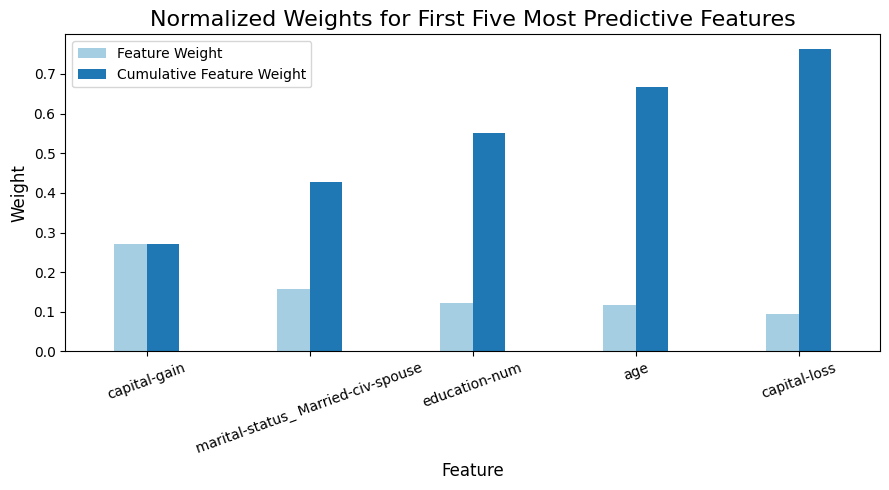

In [15]:
# Train the supervised model on the training set using .fit(X_train, y_train)
start = time()
model = best_clf.fit(X_train, y_train)
end = time()

print(f"Training time for the optimized model: {end - start:.3f} seconds")

# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Comparison to hypothesis

The five features we had expected to show more predicting power as stated in the response or question six were: 1. `capital-gain`, 2. `education`, 3. `occupation`, 4. `age` and 5. `hours-per-week`.
The five important features with the most influence selected by AdaBoost model were: 1. `capital-gain`, 2. `marital-status_Married-civ-spouse`, 3. `education-num`, 4. `age` and 5. `capital-loss`.

Seeing `capital-gain` rank first matches the intuition that investment income strongly signals earnings above `$50K`. I did have the intuition `age` and `education` were important for the target, but the idea of experience seems to be better correlated with the number of years schooling (`education-num`), or possibly, this suggest that the `education` category split may be noisy or less determining in a specific category.

From the model feature evaluation, it's understandable `capital-loss` could be an important factor too and I missed it, since `capital-loss` means also the capacity to invest which is still a proxy for wealth/income, adding to the possibility of the person to earn more than `$50K`. for `marital-status_Married-civ-spouse` category, it makes sense the correlation if we think about the possible dual-income households and career stability normally expected under those circumstances.

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [16]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
start = time()
clf = (clone(best_clf)).fit(X_train_reduced, y_train)
end = time()

print(f"Training time for the optimized model on reduced data: {end - start:.3f} seconds")
print()

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Training time for the optimized model on reduced data: 3.336 seconds

Final Model trained on full data
------
Accuracy on testing data: 0.8507
F-score on testing data: 0.7122

Final Model trained on reduced data
------
Accuracy on testing data: 0.8463
F-score on testing data: 0.7047


### When reduced features are worth it

```plaintext
Training time for the optimized model: 18.618 seconds
Training time for the optimized model on reduced data: 4.136 seconds

Final Model trained on full data
------
Accuracy on testing data: 0.8507
F-score on testing data: 0.7122

Final Model trained on reduced data
------
Accuracy on testing data: 0.8463
F-score on testing data: 0.7047
```

Using only the top five features, F-score changed by -0.0075 (-1.05%) and accuracy by -0.0044 (-0.52%) compared to using all features; training time was 4.50x faster than when using all the features (18.618 / 4.136) which converts to 77.8% reduction in training time.

A 77.8% reduction in training time and given the case it is an importan factor in our model design we must consider using the reduced data as the training set.